In [3]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz
import pydot
import matplotlib.pyplot as plt
from imblearn.combine import SMOTETomek
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score, precision_recall_curve, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
import pickle
import multiprocessing as mp  

In [4]:
def con_to_bin(x):
    if x=='BENIGN':
        return 0
    if x=='Bot':
        return 1

In [5]:
def plot_cm(classifier, predictions):
    cm = confusion_matrix(y_test, predictions)
    
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap='RdBu')
    classNames = ['Benign','Bot']
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), 
                     horizontalalignment='center', color='White')
    
    plt.show()
        
    tn, fp, fn, tp = cm.ravel()

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    F1 = 2*recall*precision/(recall+precision)

    print('Recall={0:0.3f}'.format(recall),'\nPrecision={0:0.3f}'.format(precision))
    print('F1={0:0.3f}'.format(F1))

In [6]:
def plot_aucprc(classifier, scores):
    precision, recall, _ = precision_recall_curve(y_test, scores, pos_label=0)
    average_precision = average_precision_score(y_test, scores)

    print('Average precision-recall score: {0:0.3f}'.format(
          average_precision))

    plt.plot(recall, precision, label='area = %0.3f' % average_precision, color="green")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.legend(loc="best")
    plt.show()

## Importing cleaned Dataset - 'Friday-WorkingHours-Morning.pcap_ISCX.csv'

In [7]:
#Load the data
np.random.seed(123)

data = pd.read_csv('C:/MSc_Felippe/CSC7333_Project/data/Friday-WorkingHours-Morning.pcap_ISCX.csv', 
                   na_values = ["NaN", "Infinity"], header = 0)


old_names=list(data.columns)
new_names=list(data.columns.str.replace(" ", ""))



cols = {old_names[i]: new_names[i] for i in range(len(old_names))} 
data = data.rename(columns=cols)

data = data.drop(columns=['DestinationPort'])
data.head(5)
#data = data.Label.replace(pd.factorize(data['Label'])[0])

#data.to_csv('C:/MSc_Felippe/CSC7333_Project/data/FK_Friday_Fixed_Heading.csv', sep=',', encoding='utf-8', index=False)

,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,BwdPacketLengthMax,...,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,Label
0,112740690,32,16,6448,1152,403,0,201.5,204.724205,72,...,32,3.594286e+02,1.199802e+01,380,343,16100000.0,4.988048e+05,16400000,15400000,BENIGN
1,112740560,32,16,6448,5056,403,0,201.5,204.724205,316,...,32,3.202857e+02,1.574499e+01,330,285,16100000.0,4.987937e+05,16400000,15400000,BENIGN
2,113757377,545,0,0,0,0,0,0.0,0.000000,0,...,0,9.361829e+06,7.324646e+06,18900000,19,12200000.0,6.935824e+06,20800000,5504997,BENIGN
3,100126,22,0,616,0,28,28,28.0,0.000000,0,...,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
4,54760,4,0,0,0,0,0,0.0,0.000000,0,...,0,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN


In [8]:
data.head(5)

,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,BwdPacketLengthMax,...,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,Label
0,112740690,32,16,6448,1152,403,0,201.5,204.724205,72,...,32,3.594286e+02,1.199802e+01,380,343,16100000.0,4.988048e+05,16400000,15400000,BENIGN
1,112740560,32,16,6448,5056,403,0,201.5,204.724205,316,...,32,3.202857e+02,1.574499e+01,330,285,16100000.0,4.987937e+05,16400000,15400000,BENIGN
2,113757377,545,0,0,0,0,0,0.0,0.000000,0,...,0,9.361829e+06,7.324646e+06,18900000,19,12200000.0,6.935824e+06,20800000,5504997,BENIGN
3,100126,22,0,616,0,28,28,28.0,0.000000,0,...,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
4,54760,4,0,0,0,0,0,0.0,0.000000,0,...,0,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN


In [9]:
data = data.dropna()
#data.isna().sum()
data.shape

(190911, 78)

## Selecting the top ten features which are extracted from Random Forest classifier
1. BwdPacketLengthMean
2. Init_Win_bytes_forward
3. AvgBwdSegmentSize
4. Init_Win_bytes_backward
5. AveragePacketSize
6. TotalLengthofBwdPackets
7. SubflowBwdBytes
8. BwdPackets/s
9. PacketLengthMean
10. BwdPacketLengthMax

In [19]:
#creating a dataframe to select the data containing above features and 'Label' column (target variable)

data =data[['BwdPacketLengthMean','Init_Win_bytes_forward', 'AvgBwdSegmentSize','Init_Win_bytes_backward','AveragePacketSize','TotalLengthofBwdPackets','SubflowBwdBytes','BwdPackets/s','PacketLengthMean','BwdPacketLengthMax','Label']]

In [20]:
#Present the shape of the data
print('The shape of our features is:', data.shape)

data.Label.value_counts()

The shape of our features is: (190911, 11)


BENIGN    188955
Bot         1956
Name: Label, dtype: int64

## Defining dependent and independent variables

### Factorizing y - Bening is 0 and Bot is 1

In [30]:
#Extract the values to be predicted
y_data = data.iloc[:,10]

#Bening is 0 and Bot is 1
y_data = y_data.apply(con_to_bin)

#Delete the values to be predicted from the original data frame
X_data = data.drop('Label', axis = 1)

## Best parameters obtained 

In [35]:
best_params_ = {'n_estimators': 1800,'min_samples_split': 2,'min_samples_leaf': 1,'max_features': 'auto','max_depth': 90,'criterion': 'entropy','bootstrap': True}

In [36]:
rfc = RandomForestClassifier(n_jobs=-1, random_state = 123,
                             n_estimators=best_params_['n_estimators'], 
                             criterion=best_params_['criterion'],
                             max_depth=best_params_['max_depth'],
                             min_samples_split=best_params_['min_samples_split'],
                             min_samples_leaf=best_params_['min_samples_leaf'], 
                             max_features= best_params_['max_features'],
                             bootstrap=best_params_['bootstrap']
                            )

## Handling imbalanced dataset using SMOTETomek method for balancing the target variables
## This will perform over-sampling using SMOTE and cleaning using Tomek links.

In [37]:
#Balance the data
smote = SMOTETomek(random_state=123)
X_res, y_res = smote.fit_sample(X_data, y_data)

values, counts = np.unique(y_res, axis=0, return_counts=True)
counts

array([132173, 132173], dtype=int64)

In [26]:
# Saving feature names for later use
variable_list = list(X_res.columns)

#X_res=np.array(X_res)

## Implementing Stratified K-fold cross validation
## This model selects the target variables (0 and 1 ) in same proportion to enhance model accuracy and reduce overfitting

In [ ]:
#Implementing Stratified K fold CV
accuracy=[]
gkf=RepeatedKFold(n_splits=100, random_state=123)
gkf.get_n_splits(X_res,y_res)
for train_index, val_index in gkf.split(X_res,y_res):
    X_train, X_val = X_res.iloc[train_index], X_res.iloc[val_index]
    y_train, y_val = y_res.iloc[train_index], y_res.iloc[val_index]
    
    #X_norm_train = pd.DataFrame(StandardScaler().fit_transform(X_train))
    
    rfc.fit(X_train,y_train)
    
    #X_norm_val = pd.DataFrame(StandardScaler().fit_transform(X_val))
    
    predictions = rfc.predict(X_val)
    
    score_=accuracy_score(predictions,y_val)
    accuracy.append(score_)
    
print(accuracy)

In [ ]:
#Accuracy evaluation
np.array(accuracy).mean()

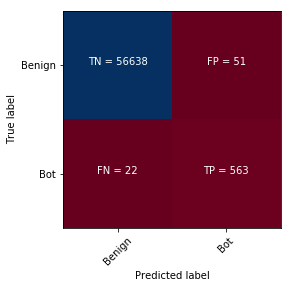

Recall=0.962 
Precision=0.917
F1=0.939
Average precision-recall score: 0.982


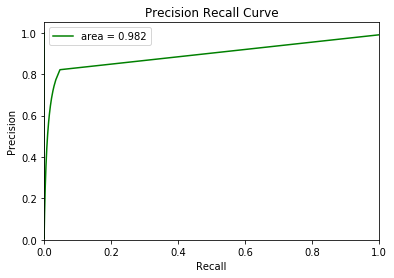

In [28]:
#X_norm_test = pd.DataFrame(StandardScaler().fit_transform(X_test), columns = X_test.columns)


y_pred = rfc.predict(X_test)
try:
    scores = rfc.decision_function(X_test)
except:
    scores = rfc.predict_proba(X_test)[:,1]

#Make plots
plot_cm(rfc, y_pred)
plot_aucprc(rfc, scores)